# Add model: translation attention ecoder-decocer over the b5 dataset

In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchtext import data
import pandas as pd
import unicodedata
import string
import re
import random
import copy
from contra_qa.plots.functions  import simple_step_plot, plot_confusion_matrix
import  matplotlib.pyplot as plt
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
from nltk.translate.bleu_score import sentence_bleu


% matplotlib inline

In [2]:
import time
import math


def asMinutes(s):
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)


def timeSince(since):
    now = time.time()
    s = now - since
    return '%s' % asMinutes(s)

### Preparing data

In [3]:
df2 = pd.read_csv("data/boolean5_train.csv")
df2_test = pd.read_csv("data/boolean5_test.csv")

df2["text"] = df2["sentence1"] + df2["sentence2"] 
df2_test["text"] = df2_test["sentence1"] + df2_test["sentence2"] 

all_sentences = list(df2.text.values) + list(df2_test.text.values)

df2train = df2.iloc[:8500]
df2valid = df2.iloc[8500:]

In [4]:
df2train.tail()

,sentence1,sentence2,and_A,and_B,label,text
8495,Roland created a shy and wonderful work of art,Roland didn't create a delightful work of art,Roland created a shy work of art,Roland created a wonderful work of art,0,Roland created a shy and wonderful work of art...
8496,Tracy created a powerful and stocky work of art,Samantha didn't create a powerful work of art,Tracy created a powerful work of art,Tracy created a stocky work of art,0,Tracy created a powerful and stocky work of ar...
8497,Joann created a repulsive and flabby work of art,Joann didn't create a polite work of art,Joann created a repulsive work of art,Joann created a flabby work of art,0,Joann created a repulsive and flabby work of a...
8498,Joshua created a jolly and black work of art,Joshua didn't create a jolly work of art,Joshua created a jolly work of art,Joshua created a black work of art,1,Joshua created a jolly and black work of art J...
8499,Alison created an ashy and helpful work of art,Alison didn't create a pitiful work of art,Alison created an ashy work of art,Alison created a helpful work of art,0,Alison created an ashy and helpful work of art...


In [5]:
SOS_token = 0
EOS_token = 1

class Lang:
    def __init__(self, name):
        self.name = name
        self.word2index = {}
        self.word2count = {}
        self.index2word = {0: "SOS", 1: "EOS"}
        self.n_words = 2  # Count SOS and EOS

    def addSentence(self, sentence):
        for word in sentence.split(' '):
            self.addWord(word)

    def addWord(self, word):
        if word not in self.word2index:
            self.word2index[word] = self.n_words
            self.word2count[word] = 1
            self.index2word[self.n_words] = word
            self.n_words += 1
        else:
            self.word2count[word] += 1

In [6]:
# Turn a Unicode string to plain ASCII, thanks to
# http://stackoverflow.com/a/518232/2809427
def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn')

# Lowercase, trim, and remove non-letter characters

def normalizeString(s):
    s = unicodeToAscii(s.lower().strip())
    s = re.sub(r"([.!?])", r" \1", s)
    s = re.sub(r"[^a-zA-Z.!?]+", r" ", s)
    return s


example = "ddddda'''~~çãpoeéééééÈ'''#$$##@!@!@AAS@#12323fdf"
print("Before:", example)
print()
print("After:", normalizeString(example))

Before: ddddda'''~~çãpoeéééééÈ'''#$$##@!@!@AAS@#12323fdf

After: ddddda capoeeeeeee ! ! aas fdf


In [7]:
pairs_A = list(zip(list(df2train.sentence1.values), list(df2train.and_A.values)))
pairs_B = list(zip(list(df2train.sentence1.values), list(df2train.and_B.values)))
pairs_A = [(normalizeString(s1), normalizeString(s2)) for s1, s2 in pairs_A]
pairs_B = [(normalizeString(s1), normalizeString(s2)) for s1, s2 in pairs_B]
pairs_A_val = list(zip(list(df2valid.sentence1.values), list(df2valid.and_A.values)))
pairs_B_val = list(zip(list(df2valid.sentence1.values), list(df2valid.and_B.values)))
pairs_A_val = [(normalizeString(s1), normalizeString(s2)) for s1, s2 in pairs_A_val]
pairs_B_val = [(normalizeString(s1), normalizeString(s2)) for s1, s2 in pairs_B_val]


In [8]:
all_text_pairs = zip(all_sentences, all_sentences)
all_text_pairs = [(normalizeString(s1), normalizeString(s2)) for s1, s2 in all_text_pairs]

In [9]:
def readLangs(lang1, lang2, pairs, reverse=False):
    # Reverse pairs, make Lang instances
    if reverse:
        pairs = [tuple(reversed(p)) for p in pairs]
        input_lang = Lang(lang2)
        output_lang = Lang(lang1)
    else:
        input_lang = Lang(lang1)
        output_lang = Lang(lang2)

    return input_lang, output_lang, pairs

In [10]:
f = lambda x: len(x.split(" "))

MAX_LENGTH = np.max(list(map(f, all_sentences)))

In [11]:
MAX_LENGTH = 20
def filterPair(p):
    cond1 = len(p[0].split(' ')) < MAX_LENGTH
    cond2 = len(p[1].split(' ')) < MAX_LENGTH 
    return cond1 and cond2

def filterPairs(pairs):
    return [pair for pair in pairs if filterPair(pair)]


In [12]:
def prepareData(lang1, lang2, pairs, reverse=False):
    input_lang, output_lang, pairs = readLangs(lang1, lang2, pairs, reverse)
    print("Read %s sentence pairs" % len(pairs))
    pairs = filterPairs(pairs)
    print("Trimmed to %s sentence pairs" % len(pairs))
    print("Counting words...")
    for pair in pairs:
        input_lang.addSentence(pair[0])
        output_lang.addSentence(pair[1])
    print("Counted words:")
    print(input_lang.name, input_lang.n_words)
    print(output_lang.name, output_lang.n_words)
    return input_lang, output_lang, pairs

In [13]:
_, _, training_pairs_A = prepareData("eng_enc",
                                             "eng_dec",
                                             pairs_A)

print()


input_lang, _, _ = prepareData("eng_enc",
                               "eng_dec",
                               all_text_pairs)

output_lang = copy.deepcopy(input_lang)

print()

print()
_, _, valid_pairs_A = prepareData("eng_enc",
                                "eng_dec",
                                pairs_A_val)

Read 8500 sentence pairs
Trimmed to 8500 sentence pairs
Counting words...
Counted words:
eng_enc 773
eng_dec 772

Read 11000 sentence pairs
Trimmed to 11000 sentence pairs
Counting words...
Counted words:
eng_enc 776
eng_dec 776


Read 1500 sentence pairs
Trimmed to 1500 sentence pairs
Counting words...
Counted words:
eng_enc 701
eng_dec 700


In [14]:
_, _, training_pairs_B = prepareData("eng_enc",
                                     "eng_dec",
                                     pairs_B)
print()
_, _, valid_pairs_B = prepareData("eng_enc",
                                "eng_dec",
                                pairs_B_val)

Read 8500 sentence pairs
Trimmed to 8500 sentence pairs
Counting words...
Counted words:
eng_enc 773
eng_dec 772

Read 1500 sentence pairs
Trimmed to 1500 sentence pairs
Counting words...
Counted words:
eng_enc 701
eng_dec 700


### sentences 2 tensors

In [15]:
def indexesFromSentence(lang, sentence):
    return [lang.word2index[word] for word in sentence.split(' ')]

In [16]:
def tensorFromSentence(lang, sentence):
    indexes = indexesFromSentence(lang, sentence)
    indexes.append(EOS_token)
    return torch.tensor(indexes, dtype=torch.long, device=device).view(-1, 1)

In [17]:
def tensorsFromPair(pair):
    input_tensor = tensorFromSentence(input_lang, pair[0])
    target_tensor = tensorFromSentence(output_lang, pair[1])
    return (input_tensor, target_tensor)

In [18]:
def tensorsFromTriple(triple):
    input_tensor = tensorFromSentence(input_lang, triple[0])
    target_tensor = tensorFromSentence(output_lang, triple[1])
    label_tensor = torch.tensor(triple[2], dtype=torch.long).view((1))
    return (input_tensor, target_tensor, label_tensor)

### models

In [19]:
class EncoderRNN(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(EncoderRNN, self).__init__()
        self.hidden_size = hidden_size
        self.embedding = nn.Embedding(input_size, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size)

    def forward(self, input, hidden):
        embedded = self.embedding(input).view(1, 1, -1)
        output = embedded
        output, hidden = self.gru(output, hidden)
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, 1, self.hidden_size, device=device)

In [20]:
class AttnDecoderRNN(nn.Module):
    def __init__(self, hidden_size, output_size, dropout_p=0.1, max_length=MAX_LENGTH):
        super(AttnDecoderRNN, self).__init__()
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.dropout_p = dropout_p
        self.max_length = max_length

        self.embedding = nn.Embedding(self.output_size, self.hidden_size)
        self.attn = nn.Linear(self.hidden_size * 2, self.max_length)
        self.attn_combine = nn.Linear(self.hidden_size * 2, self.hidden_size)
        self.dropout = nn.Dropout(self.dropout_p)
        self.gru = nn.GRU(self.hidden_size, self.hidden_size)
        self.out = nn.Linear(self.hidden_size, self.output_size)

    def forward(self, input, hidden, encoder_outputs):
        embedded = self.embedding(input).view(1, 1, -1)
        embedded = self.dropout(embedded)

        attn_weights = F.softmax(
            self.attn(torch.cat((embedded[0], hidden[0]), 1)), dim=1)
        attn_applied = torch.bmm(attn_weights.unsqueeze(0),
                                 encoder_outputs.unsqueeze(0))
        output = torch.cat((embedded[0], attn_applied[0]), 1)
        output = self.attn_combine(output).unsqueeze(0)

        output = F.relu(output)
        output, hidden = self.gru(output, hidden)

        output = F.log_softmax(self.out(output[0]), dim=1)
        return output, hidden, attn_weights

    def initHidden(self):
        return torch.zeros(1, 1, self.hidden_size, device=device)

In [21]:
hidden_size = 256
eng_enc_v_size = input_lang.n_words
eng_dec_v_size = output_lang.n_words

In [22]:
input_lang.n_words

776

In [23]:
encoderA = EncoderRNN(eng_enc_v_size, hidden_size)
decoderA = AttnDecoderRNN(hidden_size, eng_dec_v_size)
encoderA.load_state_dict(torch.load("b5_encoder1_att.pkl"))
decoderA.load_state_dict(torch.load("b5_decoder1_att.pkl"))

In [24]:
encoderB = EncoderRNN(eng_enc_v_size, hidden_size)
decoderB = AttnDecoderRNN(hidden_size, eng_dec_v_size)
encoderB.load_state_dict(torch.load("b5_encoder2_att.pkl"))
decoderB.load_state_dict(torch.load("b5_decoder2_att.pkl"))

## translating

In [25]:
def translate(encoder,
              decoder,
              sentence,
              max_length=MAX_LENGTH):
    with torch.no_grad():
        input_tensor = tensorFromSentence(input_lang, sentence)
        input_length = input_tensor.size()[0]
        encoder_hidden = encoder.initHidden()

        encoder_outputs = torch.zeros(
            max_length, encoder.hidden_size, device=device)

        for ei in range(input_length):
            encoder_output, encoder_hidden = encoder(input_tensor[ei],
                                                     encoder_hidden)
            encoder_outputs[ei] += encoder_output[0, 0]

        decoder_input = torch.tensor([[SOS_token]], device=device)  # SOS

        decoder_hidden = encoder_hidden

        decoded_words = []

        for di in range(max_length):
            decoder_output, decoder_hidden, decoder_attention = decoder(decoder_input, decoder_hidden, encoder_outputs)
            _, topone = decoder_output.data.topk(1)
            if topone.item() == EOS_token:
                decoded_words.append('<EOS>')
                break
            else:
                decoded_words.append(output_lang.index2word[topone.item()])

            decoder_input = topone.squeeze().detach()

        return " ".join(decoded_words)

## translation of a trained model: and A

In [26]:
for t in training_pairs_A[0:3]:
    print("input_sentence : " + t[0])
    neural_translation = translate(encoderA,
                                   decoderA,
                                   t[0],
                                   max_length=MAX_LENGTH)
    print("neural translation : " + neural_translation)
    reference = t[1] + ' <EOS>'
    print("reference translation : " + reference)
    reference = reference.split(" ")
    candidate = neural_translation.split(" ")
    score = sentence_bleu([reference], candidate)
    print("blue score = {:.2f}".format(score))
    print()

input_sentence : jeffery created a silly and vast work of art
neural translation : brenda created a blue work of art <EOS>
reference translation : jeffery created a silly work of art <EOS>
blue score = 0.41

input_sentence : hilda created a zealous and better work of art
neural translation : brenda created a pitiful work of art <EOS>
reference translation : hilda created a zealous work of art <EOS>
blue score = 0.41

input_sentence : cheryl created an ugly and obedient work of art
neural translation : brenda created an ugly work of art <EOS>
reference translation : cheryl created an ugly work of art <EOS>
blue score = 0.84



## translation of a trained model: and B

In [27]:
for t in training_pairs_B[0:3]:
    print("input_sentence : " + t[0])
    neural_translation = translate(encoderB,
                                   decoderB,
                                   t[0],
                                   max_length=MAX_LENGTH)
    print("neural translation : " + neural_translation)
    reference = t[1] + ' <EOS>'
    print("reference translation : " + reference)
    reference = reference.split(" ")
    candidate = neural_translation.split(" ")
    score = sentence_bleu([reference], candidate)
    print("blue score = {:.2f}".format(score))
    print()

input_sentence : jeffery created a silly and vast work of art
neural translation : marion created a vast work of art <EOS>
reference translation : jeffery created a vast work of art <EOS>
blue score = 0.84

input_sentence : hilda created a zealous and better work of art
neural translation : marion created a better work of art <EOS>
reference translation : hilda created a better work of art <EOS>
blue score = 0.84

input_sentence : cheryl created an ugly and obedient work of art
neural translation : jessie created an obedient work of art <EOS>
reference translation : cheryl created an obedient work of art <EOS>
blue score = 0.84



## Defining the And model

model inner working:

- $s_1$ is the first sentence (e.g., 'penny is thankful and naomi is alive')

- $s_2$ is the second sentence (e.g., 'penny is not alive')

- $h_A = dec_{A}(enc_{A}(s_1, \vec{0}))$

- $h_B = dec_{B}(enc_{B}(s_1, \vec{0}))$

- $h_{inf} = \sigma (W[h_A ;h_B] + b)$

- $e = enc_{A}(s_2, h_{inf})$

- $\hat{y} = softmax(We + b)$

In [28]:
class AndModel(nn.Module):
    def __init__(self,
                 encoderA,
                 decoderA,
                 encoderB,
                 decoderB,
                 hidden_size,
                 output_size,
                 max_length,
                 input_lang,
                 target_lang,
                 SOS_token=0,
                 EOS_token=1):
        super(AndModel, self).__init__()
        self.max_length = max_length
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.encoderA = encoderA
        self.decoderA = decoderA
        self.encoderB = encoderB
        self.decoderB = decoderB
        self.input_lang = input_lang
        self.target_lang = target_lang
        self.SOS_token = SOS_token
        self.EOS_token = EOS_token
        self.fc_inf = nn.Linear(hidden_size * 2, hidden_size)
        self.fc_out = nn.Linear(hidden_size, output_size)
        
    
    def encode(self,
               sentence,
               encoder,
               is_tensor,
               hidden=None):
        if not is_tensor:
            input_tensor = tensorFromSentence(self.input_lang, sentence)
        else:
            input_tensor = sentence

        input_length = input_tensor.size()[0]
        
        if hidden is None:
            encoder_hidden = encoder.initHidden()
        else:
            encoder_hidden = hidden
        
        encoder_outputs = torch.zeros(self.max_length,
                                      encoder.hidden_size,
                                      device=device)
        
        for ei in range(input_length):
            encoder_output, encoder_hidden = encoder(input_tensor[ei],
                                        encoder_hidden)
            encoder_outputs[ei] += encoder_output[0, 0]
            
        self.encoder_outputs = encoder_outputs

        return encoder_hidden
    
    
    def decode(self,
               tensor,
               decoder,
               out_tensor):
        
        decoder_input = torch.tensor([[self.SOS_token]], device=device)
        decoder_hidden = tensor
        decoded_words = []

        for di in range(self.max_length):
            decoder_output, decoder_hidden, decoder_attention = decoder(
                decoder_input, decoder_hidden, self.encoder_outputs)
            _, topone = decoder_output.data.topk(1)
            if topone.item() == self.EOS_token:
                decoded_words.append('<EOS>')
                break
            else:
                decoded_words.append(self.target_lang.index2word[topone.item()])

            decoder_input = topone.squeeze().detach()
        
        if not out_tensor:
            output = " ".join(decoded_words)
        else:
            output = decoder_hidden

        return output
    
    def sen2vec(self, sentence, encoder, decoder, is_tensor, out_tensor):
        encoded = self.encode(sentence, encoder, is_tensor)
        vec = self.decode(encoded, decoder, out_tensor)
        return vec
    
    def sen2vecA(self, sentence, is_tensor):
        encoded = self.encode(sentence, self.encoderA, is_tensor)
        vec = self.decode(encoded, self.decoderA, out_tensor=True)
        return vec
    
    def sen2vecB(self, sentence, is_tensor):
        encoded = self.encode(sentence, self.encoderB, is_tensor)
        vec = self.decode(encoded, self.decoderB, out_tensor=True)
        return vec
    
    def forward(self, s1, s2):
        hA = self.sen2vecA(s1, is_tensor=True)
        hB = self.sen2vecB(s1, is_tensor=True)
#         h_inf = torch.cat([hA, hB], dim=2).squeeze(1)
#         h_inf = torch.sigmoid(self.fc_inf(h_inf))
#         h_inf = h_inf.view((1, h_inf.shape[0], h_inf.shape[1])) 
        h_inf = hA * hB
        e = self.encode(s2,
                        self.encoderA,
                        hidden=h_inf,
                        is_tensor=True)
        output = self.fc_out(e).squeeze(1)
        
        return output
    

    def predict(self, s1, s2):
        out = self.forward(s1, s2)
        softmax = nn.Softmax(dim=1)
        out = softmax(out)
        indices = torch.argmax(out, 1)
        return indices

        


In [29]:
addmodel = AndModel(encoderA,
                    decoderA,
                     encoderB,
                     decoderB,
                     hidden_size=256,
                     output_size=2,
                     max_length=MAX_LENGTH,
                     input_lang=input_lang,
                     target_lang=output_lang)

Test encoding decoding

In [30]:
for ex in training_pairs_B[0:3]:
    print("===========")
    ex = ex[0]
    print("s1:\n")
    print(ex)
    print()

    
    ex_A = addmodel.sen2vec(ex,
                     addmodel.encoderA,
                     addmodel.decoderA,
                     is_tensor=False,
                     out_tensor=False)
    
    ex_B = addmodel.sen2vec(ex,
                     addmodel.encoderB,
                     addmodel.decoderB,
                     is_tensor=False,
                     out_tensor=False)

    print("inference A:\n")
    print(ex_A)
    print()
    print("inference B:\n")
    print(ex_B)

s1:

jeffery created a silly and vast work of art

inference A:

brenda created a blue work of art <EOS>

inference B:

marion created a vast work of art <EOS>
s1:

hilda created a zealous and better work of art

inference A:

brenda created a pitiful work of art <EOS>

inference B:

marion created a better work of art <EOS>
s1:

cheryl created an ugly and obedient work of art

inference A:

brenda created an ugly work of art <EOS>

inference B:

jessie created an obedient work of art <EOS>


In [31]:
for ex in training_pairs_B[0:1]:
    print("===========")
    ex = ex[0]
    print("s1:\n")
    print(ex)
    print()

    ex_A = addmodel.sen2vecA(ex,is_tensor=False)
    ex_B = addmodel.sen2vecB(ex,is_tensor=False)
    
    print(ex_A)
    print()
    print(ex_B)

s1:

jeffery created a silly and vast work of art

tensor([[[ 0.4809, -0.9748, -0.9058,  0.7731,  0.9287,  0.3540,  0.9009,
           0.0062, -0.4778,  0.9464, -0.9692,  0.9541, -0.0216, -0.8225,
          -0.8939, -0.4950,  0.9780, -0.9481, -0.9533,  0.9515,  0.6133,
           0.9660,  0.9926,  0.2594,  0.9453,  0.9918,  0.9857,  0.3806,
           0.7885,  0.2965, -0.8093, -0.8961,  0.9822,  0.8418, -0.8944,
           0.9348,  0.9109, -0.4628, -0.9292,  0.7809, -0.2861, -0.7080,
           0.9825, -0.1126, -0.9562,  0.1050,  0.3561, -0.9310,  0.2606,
          -0.9157,  0.4951,  0.8474,  0.8722,  0.7122, -0.1236, -0.5372,
           0.9738,  0.9554,  0.9591, -0.9547, -0.9398, -0.8006, -0.9736,
          -0.9475, -0.8019, -0.9424,  0.6299,  0.6865, -0.9671, -0.9345,
          -0.7984,  0.6900,  0.9609,  0.7677,  0.9908,  0.1710, -0.9879,
           0.5875, -0.4956, -0.8926,  0.6362, -0.4432,  0.9624, -0.8671,
          -0.9628, -0.3785, -0.9462, -0.3702,  0.8136, -0.9806, -0.7006,


In [32]:
train_triples = zip(list(df2train.sentence1.values), list(df2train.sentence2.values), list(df2train.label.values))
train_triples = [(normalizeString(s1), normalizeString(s2), l) for s1, s2, l in train_triples]
train_triples_t = [tensorsFromTriple(t) for t in train_triples]

In [33]:
train_triples = zip(list(df2train.sentence1.values), list(df2train.sentence2.values), list(df2train.label.values))
train_triples = [(normalizeString(s1), normalizeString(s2), l) for s1, s2, l in train_triples]
train_triples_t = [tensorsFromTriple(t) for t in train_triples]

In [34]:
valid_triples = zip(list(df2valid.sentence1.values), list(df2valid.sentence2.values), list(df2valid.label.values))
valid_triples = [(normalizeString(s1), normalizeString(s2), l) for s1, s2, l in valid_triples]
valid_triples_t = [tensorsFromTriple(t) for t in valid_triples]

In [35]:
len(valid_triples_t)

1500

In [36]:
test_triples = zip(list(df2_test.sentence1.values), list(df2_test.sentence2.values), list(df2_test.label.values))
test_triples = [(normalizeString(s1), normalizeString(s2), l) for s1, s2, l in test_triples]
test_triples_t = [tensorsFromTriple(t) for t in test_triples]

In [37]:
example = train_triples[0]
print(example)
example_t = train_triples_t[0]
print(example_t)

('jeffery created a silly and vast work of art', 'jeffery didn t create a silly work of art', 1)
(tensor([[ 2],
        [ 3],
        [ 4],
        [ 5],
        [ 6],
        [ 7],
        [ 8],
        [ 9],
        [10],
        [ 1]]), tensor([[ 2],
        [11],
        [12],
        [13],
        [ 4],
        [ 5],
        [ 8],
        [ 9],
        [10],
        [ 1]]), tensor([1]))


## Prediction BEFORE training

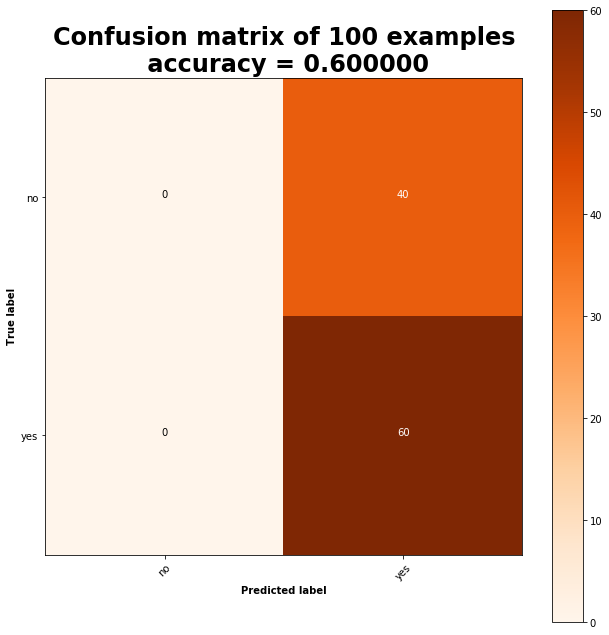

In [38]:
n_iters = 100
training_pairs_little = [random.choice(train_triples_t) for i in range(n_iters)]
predictions = []
labels = []

for i in range(n_iters):
    s1, s2, label = training_pairs_little[i]
    pred = addmodel.predict(s1, s2)
    label = label.item()
    pred = pred.item()
    predictions.append(pred)
    labels.append(label)

plot_confusion_matrix(labels,
                      predictions,
                      classes=["no", "yes"],
                      path="confusion_matrix.png")

### Training functions

In [39]:
def CEtrain(s1_tensor,
            s2_tensor,
            label,
            model,
            optimizer,
            criterion):
    
    model.train()
    optimizer.zero_grad()
    logits = model(s1_tensor, s2_tensor)
    loss = criterion(logits, label)
    loss.backward()
    optimizer.step()
    return loss

Test CEtrain

In [40]:
CE = nn.CrossEntropyLoss()
addmodel_opt = torch.optim.SGD(addmodel.parameters(), lr= 0.3)

loss = CEtrain(s1_tensor=example_t[0],
               s2_tensor=example_t[1],
               label=example_t[2],
               model=addmodel,
               optimizer=addmodel_opt,
               criterion=CE)
assert type(loss.item()) == float 

## Little example of training

epoch 1/10 1m 26s mean loss = 1.35
epoch 2/10 1m 24s mean loss = 0.88
epoch 3/10 1m 28s mean loss = 0.84
epoch 4/10 1m 33s mean loss = 0.83
epoch 5/10 1m 26s mean loss = 0.81
epoch 6/10 1m 20s mean loss = 0.78
epoch 7/10 1m 26s mean loss = 0.78
epoch 8/10 1m 18s mean loss = 0.77
epoch 9/10 1m 10s mean loss = 0.77
epoch 10/10 1m 7s mean loss = 0.76


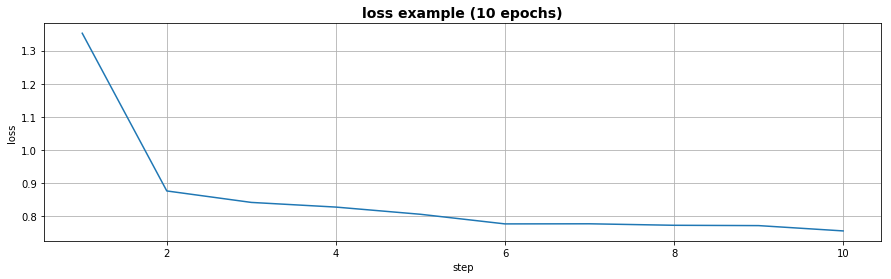

In [41]:
epochs = 10
learning_rate = 0.1

CE = nn.CrossEntropyLoss()

encoderA = EncoderRNN(eng_enc_v_size, hidden_size)
decoderA = AttnDecoderRNN(hidden_size, eng_dec_v_size)
encoderA.load_state_dict(torch.load("b5_encoder1_att.pkl"))
decoderA.load_state_dict(torch.load("b5_decoder1_att.pkl"))
encoderB = EncoderRNN(eng_enc_v_size, hidden_size)
decoderB = AttnDecoderRNN(hidden_size, eng_dec_v_size)
encoderB.load_state_dict(torch.load("b5_encoder2_att.pkl"))
decoderB.load_state_dict(torch.load("b5_decoder2_att.pkl"))

addmodel = AndModel(encoderA,
                    decoderA,
                    encoderB,
                    decoderB,
                    hidden_size=256,
                    output_size=2,
                    max_length=MAX_LENGTH,
                    input_lang=input_lang,
                    target_lang=output_lang)



# # for model in [encoderA, decoderA, encoderB, decoderB]:
# for model in [encoderB, decoderB]:
#     for param in model.parameters():
#         param.requires_grad = False

# addmodel_opt = torch.optim.SGD(addmodel.parameters(), lr= learning_rate)
addmodel_opt = torch.optim.Adagrad(addmodel.parameters(), lr= learning_rate)
# addmodel_opt = torch.optim.Adadelta(addmodel.parameters(), lr= learning_rate)
# addmodel_opt = torch.optim.Adam(addmodel.parameters(), lr= learning_rate)
# addmodel_opt = torch.optim.SparseAdam(addmodel.parameters(), lr= learning_rate)
# addmodel_opt = torch.optim.RMSprop(addmodel.parameters(), lr= learning_rate)





losses_per_epoch = []

for i in range(epochs):
    losses = []
    start = time.time()
    n_iters = 1000
    training_pairs_little = [random.choice(train_triples_t) for i in range(n_iters)]
    for t in training_pairs_little:
        s1, s2, label = t    
        loss = CEtrain(s1_tensor=s1,
                       s2_tensor=s2,
                       label=label,
                       model=addmodel,
                       optimizer=addmodel_opt,
                       criterion=CE)
        losses.append(loss.item())
    mean_loss = np.mean(losses)
    losses_per_epoch.append(mean_loss)
    print("epoch {}/{}".format(i+1, epochs), timeSince(start), "mean loss = {:.2f}".format(mean_loss))

simple_step_plot([losses_per_epoch],
                 "loss",
                 "loss example ({} epochs)".format(epochs),
                 "loss_example.png",
                  figsize=(15,4))

## Prediction AFTER training

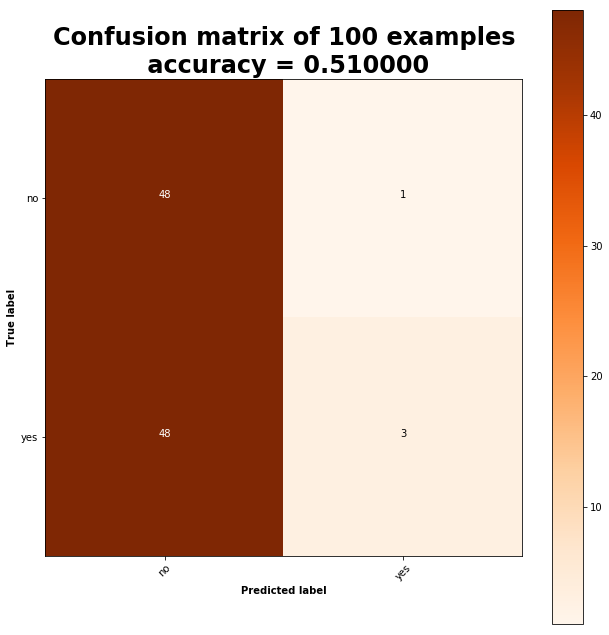

In [42]:
n_iters = 100
training_pairs_little = [random.choice(train_triples_t) for i in range(n_iters)]
predictions = []
labels = []

for i in range(n_iters):
    s1, s2, label = training_pairs_little[i]
    pred = addmodel.predict(s1, s2)
    label = label.item()
    pred = pred.item()
    predictions.append(pred)
    labels.append(label)

plot_confusion_matrix(labels,
                      predictions,
                      classes=["no", "yes"],
                      path="confusion_matrix.png")

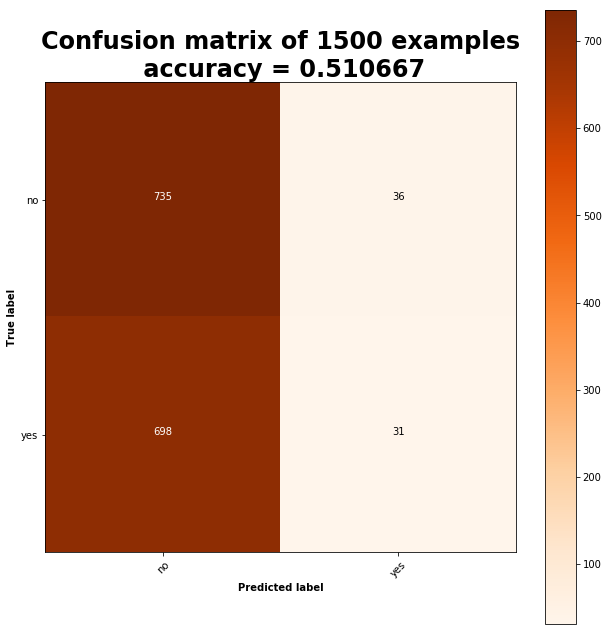

In [43]:
n_iters = len(valid_triples_t)
valid_pairs_little = [random.choice(valid_triples_t) for i in range(n_iters)]
predictions = []
labels = []

for i in range(n_iters):
    s1, s2, label = valid_pairs_little[i]
    pred = addmodel.predict(s1, s2)
    label = label.item()
    pred = pred.item()
    predictions.append(pred)
    labels.append(label)

plot_confusion_matrix(labels,
                      predictions,
                      classes=["no", "yes"],
                      path="confusion_matrix.png")

In [44]:
torch.save(addmodel.state_dict(), "b5_dot.pkl")

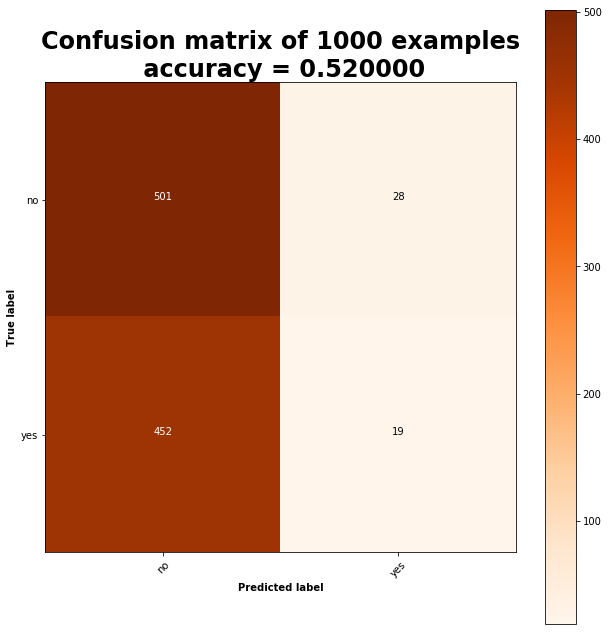

In [45]:
n_iters = len(test_triples_t)
training_pairs_little = [random.choice(test_triples_t) for i in range(n_iters)]
predictions = []
labels = []

for i in range(n_iters):
    s1, s2, label = training_pairs_little[i]
    pred = addmodel.predict(s1, s2)
    label = label.item()
    pred = pred.item()
    predictions.append(pred)
    labels.append(label)

plot_confusion_matrix(labels,
                      predictions,
                      classes=["no", "yes"],
                      path="confusion_matrix.png")